# Load config

In [6]:
from mmengine import Config
from mmengine.runner import Runner
from mmseg.apis import init_model, inference_model, show_result_pyplot
import mmcv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from mmseg.datasets import DynamicEarthNet

def load_config():
    # cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_4xb2-40k_dynamicearthnet-512x1024.py')
    # cfg = Config.fromfile('configs/pidnet/pidnet-s_2xb6-120k_1024x1024-dynamicearthnet.py')

    # cfg = Config.fromfile('configs/unet/unet-s5-d16_fcn_4xb4-20k_dynamicearthnet-64x64.py')
    cfg = Config.fromfile('configs/unet/unet_s5-d16_deeplabv3_4xb4-20k_dynamicearthnet-128x128.py')
    # cfg = Config.fromfile('configs/unet/unet-s5-d16_pspnet_4xb4-20k_dynamicearthnet-64x64.py')


    # print(f'Config:\n{cfg.pretty_text}')
    # cfg.model.data_preprocessor.size=(1024, 1024)

    cfg.work_dir = 'run_check/'
    # cfg.dataset_type = 'DynamicEarthNet'
    cfg.data_root = '/home/Hung_Data/HungData/mmseg_data/Datasets/DynamicEarthNet/data_monthly'
    # cfg.train_dataloader.dataset.data_prefix=dict(img_path='planet', seg_map_path='labels')
    cfg.train_dataloader.dataset.data_root= cfg.data_root
    # cfg.train_dataloader.batch_size=2

    # cfg.val_dataloader.dataset.data_prefix=dict(img_path='planet', seg_map_path='labels')
    # cfg.val_dataloader.dataset.type= cfg.dataset_type
    cfg.val_dataloader.dataset.data_root= cfg.data_root
    # cfg.val_dataloader.batch_size=1



    cfg.train_pipeline = [
        dict(type='LoadImageFromTIF'),
        dict(type='LoadAnnotations'),

        # dict(type='Resize', scale=(128, 128), keep_ratio=True),

        # dict(type='RandomResize', scale=(1024, 1024), ratio_range=(0.5, 2.0), keep_ratio=True),
        # dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
        # dict(type='RandomFlip', prob=0.5),
        dict(type='PackSegInputs')
    ]

    cfg.test_pipeline = [
        dict(type='LoadImageFromTIF'),
        # dict(type='Resize', scale=(128, 128), keep_ratio=True),
        # add loading annotation after ``Resize`` because ground truth
        # does not need to do resize data transform
        dict(type='LoadAnnotations'),
        dict(type='PackSegInputs')
    ]


    cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
    cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
    return cfg


# run check model

/home/Hung_Data/HungData/mmseg_data/mod_mmseg/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/Hung_Data/HungData/mmseg_data/mod_mmseg/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /home/Hung_Data/HungData/mmseg_data/mod_mmseg/run_check/iter_60000.pth
06/18 11:07:14 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


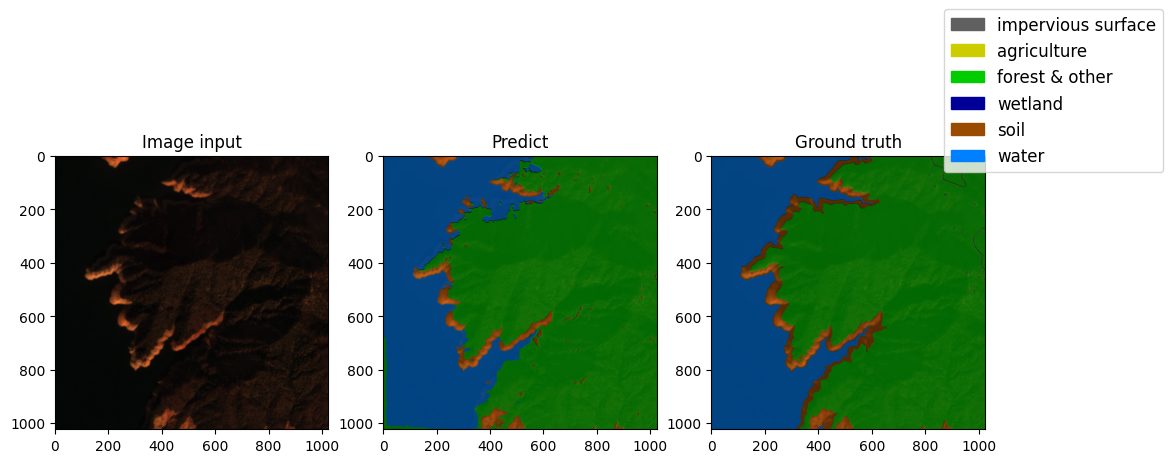

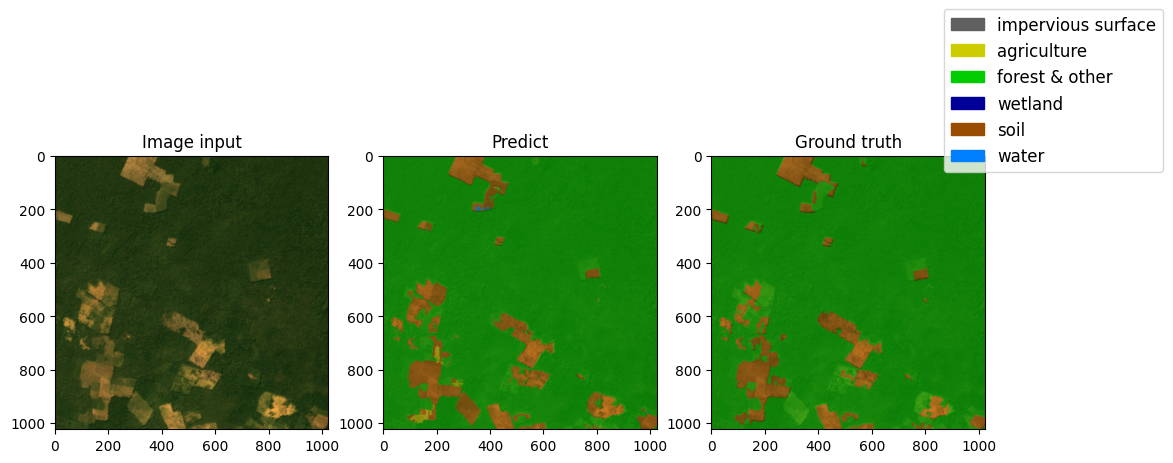

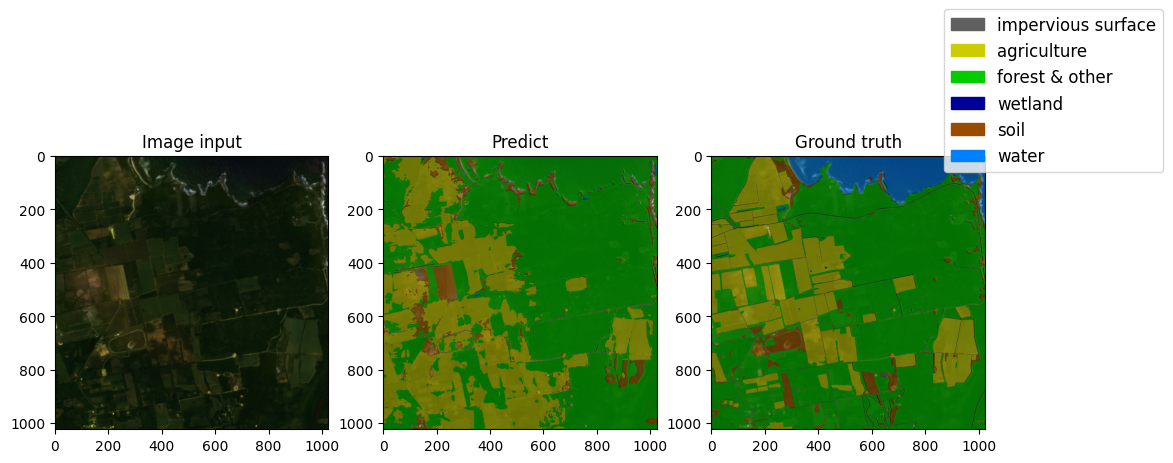

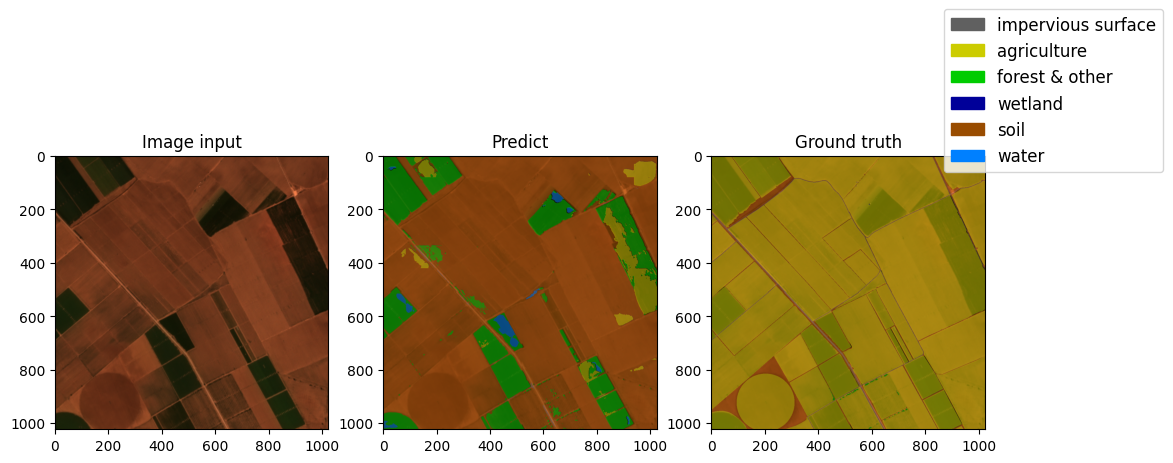

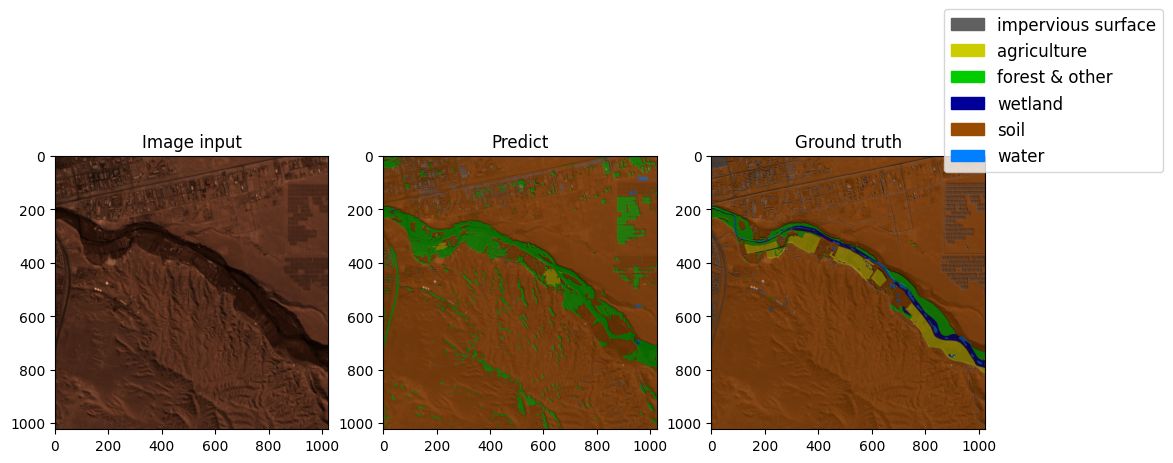

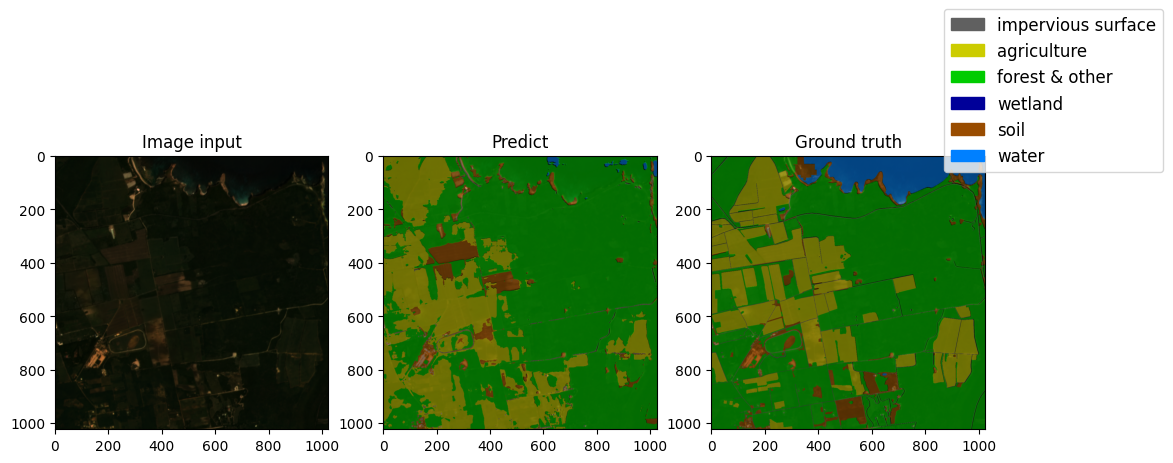

In [7]:
# Init the model from the config and the checkpoint
cfg = load_config()
checkpoint_path = '/home/Hung_Data/HungData/mmseg_data/mod_mmseg/run_check/iter_60000.pth'
# checkpoint_path = '/home/Hung_Data/HungData/mmseg_data/mod_mmseg/run_check/weight_pid/iter_120000.pth'
model = init_model(cfg, checkpoint_path, 'cuda:1')

val_dataloader = Runner.build_dataloader(cfg.val_dataloader)
train_dataloader = Runner.build_dataloader(cfg.train_dataloader)

img0_sample = train_dataloader.dataset[0]['data_samples']
img1_sample = val_dataloader.dataset[0]['data_samples']
img2_sample = val_dataloader.dataset[24]['data_samples']
img3_sample = val_dataloader.dataset[48]['data_samples']
img4_sample = val_dataloader.dataset[72]['data_samples']
img5_sample = val_dataloader.dataset[94]['data_samples']

img0 = np.transpose(train_dataloader.dataset[0]['inputs'].numpy(), (1,2,0)).astype(np.uint8)
img1 = np.transpose(val_dataloader.dataset[0]['inputs'].numpy(), (1,2,0)).astype(np.uint8)
img2 = np.transpose(val_dataloader.dataset[24]['inputs'].numpy(), (1,2,0)).astype(np.uint8)
img3 = np.transpose(val_dataloader.dataset[48]['inputs'].numpy(), (1,2,0)).astype(np.uint8)
img4 = np.transpose(val_dataloader.dataset[72]['inputs'].numpy(), (1,2,0)).astype(np.uint8)
img5 = np.transpose(val_dataloader.dataset[94]['inputs'].numpy(), (1,2,0)).astype(np.uint8)

# img0 = mmcv.imread(img0_sample.img_path)
# img1 = mmcv.imread(img1_sample.img_path)
# img2 = mmcv.imread(img2_sample.img_path)
# img3 = mmcv.imread(img3_sample.img_path)
imgs = [img0, img1, img2, img3, img4, img5]
imgs_sample = [img0_sample, img1_sample, img2_sample, img3_sample, img4_sample, img5_sample]

# dataset = DynamicEarthNet(data_root=val_dataloader.dataset.data_prefix, data_prefix=val_dataloader.dataset.data_prefix,img_suffix='.png', seg_map_suffix='.png',test_mode=False, pipeline=cfg.test_pipeline)
patches = [mpatches.Patch(color=np.array(val_dataloader.dataset.metainfo['palette'][i])/255., 
                          label=val_dataloader.dataset.metainfo['classes'][i]) for i in range(6)]
# put those patched as legend-handles into the legend


for sample, img in zip(imgs_sample, imgs):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
    fig.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc="center right", borderaxespad=0.1,  fontsize='large')
    result = inference_model(model, img)
    ax1.set_title('Image input')
    ax1.imshow(img)
    # plt.figure(figsize=(6, 4))
    vis_result = show_result_pyplot(model, img, result)
    ax2.set_title('Predict')
    ax2.imshow(vis_result)
    # plt.figure(figsize=(6, 4))
    vis_result = show_result_pyplot(model, img, sample)
    ax3.set_title('Ground truth')
    ax3.imshow(vis_result)
    


In [8]:

# img = np.transpose(val_dataloader.dataset[0]['inputs'].numpy(), (1,2,0)).astype(np.uint8)
# b = np.transpose(a, (1,2,0))
# plt.imshow(b.astype(np.uint8))
# plt.show()

# def _read_image_as_np(path):
#     import numpy as np
#     from PIL import Image
#     with open(path, 'rb') as f:
#         return np.array(Image.open(f))
# pathcheck = '/home/Hung_Data/HungData/mmseg_data/Datasets/DynamicEarthNet/data_monthly/predicts/load_with_tif/36N_26E-144N_4881_3344_13_PF-SR_2019-03-01.png'
# img = _read_image_as_np(pathcheck)
# img.shape

# inference and save image predict

In [9]:
!export CUDA_VISIBLE_DEVICES=1

In [10]:
cfg = load_config()

checkpoint_path = '/home/Hung_Data/HungData/mmseg_data/mod_mmseg/run_check/iter_60000.pth'
cfg.load_from = checkpoint_path
cfg.test_evaluator['output_dir'] = '/home/Hung_Data/HungData/mmseg_data/Datasets/DynamicEarthNet/data_monthly/predicts/load_with_tif/'
cfg.test_evaluator['keep_results'] = True

# build the runner from config
runner = Runner.from_cfg(cfg)

# start testing
runner.test()

06/18 11:08:04 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.16 (default, Mar  2 2023, 03:21:46) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 1090729283
    GPU 0: NVIDIA TITAN RTX
    GPU 1: NVIDIA GeForce RTX 2080 Ti
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.1, V11.1.105
    GCC: gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
    PyTorch: 1.10.1+cu102
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 10.2
  - NVCC architecture flags: -gencode;arch=compute_37,code=

/home/hungnguyen/miniconda3/envs/mmseg/lib/python3.8/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


06/18 11:08:07 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
06/18 11:08:07 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/home/Hung_Data/HungData/mmseg_data/mod_mmseg/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


06/18 11:08:13 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
Loads checkpoint by local backend from path: /home/Hung_Data/HungData/mmseg_data/mod_mmseg/run_check/iter_60000.pth
06/18 11:08:15 - mmengine - INFO - Load checkpoint from /home/Hung_Data/HungData/mmseg_data/mod_mmseg/run_check/iter_60000.pth
06/18 11:10:24 - mmengine - INFO - Iter(test) [ 50/120]    eta: 0:03:01  time: 2.5442  data_time: 0.0056  memory: 485  
06/18 11:12:33 - mmengine - INFO - Iter(test) [100/120]    eta: 0:00:51  time: 2.5980  data_time: 0.0054  memory: 485  
06/18 11:13:24 - mmengine - INFO - per class results:
06/18 11:13:24 - mmengine - INFO - 
+--------------------+-------+-------+
|       Class        |  IoU  |  Acc  |
+--------------------+-------+-------+
| impervious surface |  5.25 | 12.35 |
|    agriculture     | 15.46 | 17.17 |
|   forest & other   | 56.79 | 74.81 |
|      wetland       |  0.0  |  0.0  |
|        soil        | 43.59 | 86.17 |
|       water        |  7.91

{'aAcc': 56.65, 'mIoU': 21.5, 'mAcc': 33.11}

In [11]:
+--------------------+-------+-------+
|       Class        |  IoU  |  Acc  |
+--------------------+-------+-------+
| impervious surface |  5.25 | 12.35 |
|    agriculture     | 15.46 | 17.17 |
|   forest & other   | 56.79 | 74.81 |
|      wetland       |  0.0  |  0.0  |
|        soil        | 43.59 | 86.17 |
|       water        |  7.91 |  8.2  |
+--------------------+-------+-------+

SyntaxError: invalid syntax (831426813.py, line 1)

# validation

In [ ]:

from mmengine import Config
from mmengine.runner import Runner

checkpoint_path = '/home/Hung_Data/HungData/mmseg_data/mod_mmseg/run_check/iter_60000.pth'

# cfg = Config.fromfile('configs/pidnet/pidnet-s_2xb6-120k_1024x1024-dynamicearthnet.py')
cfg = Config.fromfile('configs/unet/unet-s5-d16_pspnet_4xb4-20k_dynamicearthnet-64x64.py')

cfg.work_dir = 'run_check/'
cfg.data_root = '/home/Hung_Data/HungData/mmseg_data/Datasets/DynamicEarthNet/data_monthly'


cfg.val_dataloader.dataset.data_root= cfg.data_root

# checkpoint_path = '/home/Hung_Data/HungData/mmseg_data/mod_mmseg/run_check/iter_319400.pth'

cfg.load_from = checkpoint_path
runner = Runner.from_cfg(cfg)
# start training
runner.val()


# check visualizer

In [ ]:
import numpy as np
import torch
from mmengine.structures import PixelData
from mmseg.structures import SegDataSample
from mmseg.visualization import SegLocalVisualizer
from mmcv.transforms import LoadImageFromFile

visualizer = SegLocalVisualizer()
visualizer.dataset_meta = dict(
        classes=val_dataloader.dataset.metainfo['classes'],
        palette=val_dataloader.dataset.metainfo['palette'])

image = mmcv.imread(val_dataloader.dataset[0]['data_samples'].img_path)
result = val_dataloader.dataset[0]['data_samples']
visualizer.add_datasample(
        name='check visualizer',
        image=image,
        data_sample=result,
        show=True)

img = visualizer.get_image()
plt.imshow(img)